In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from read_network_v2 import get_network
import os
import seaborn as sns
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize']=(15,15)

from functools import reduce

lg=get_network() # get network per year in a list

def nrml(a):    # Normalize in [0,1]
    return (a - a.min()) / (a.max() - a.min())


def nrml_(a):   # Normalize in [-1,1]
    return 2*(a - a.min()) / (a.max() - a.min()) -1

In [2]:
from utilidades import get_mean_af,annotated_plot,load_data
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG_V3.csv') # imports and exports of commodities

In [3]:
path='datasetsV2'

In [4]:
dict_afs=load_data()

In [131]:
#SOLO para probar los datos en R.
af=dict_afs['af_ye']
af=af.rename(columns={af.columns[0]:'country.value',af.columns[1]:'date'})
af=pd.DataFrame({'country':af['country.value'],'year':af.date,'af':af.iloc[:,8]})
af_piv=af.pivot(index='country',columns='year',values='af').dropna()

# af_piv.T.reset_index().to_csv("af_R_ex_pr2.csv")

In [115]:
af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7502 entries, 0 to 7501
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country.value  7502 non-null   object 
 1   date           7502 non-null   int64  
 2   af_in_pr       3054 non-null   float64
 3   af_in_vl       3054 non-null   float64
 4   af_ex_pr       4490 non-null   float64
 5   af_ex_vl       4486 non-null   float64
 6   af_in_pr2      3054 non-null   float64
 7   af_in_vl2      3054 non-null   float64
 8   af_ex_pr2      4490 non-null   float64
 9   af_ex_vl2      4486 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 586.2+ KB


In [ ]:
#### Total imports value - tot_imp_v
tot_imp_vl=df[df.Element=='Import Value'].groupby('importer')['Value'].sum() # compute total imports value

#### Total exports value - tot_exp_vl
tot_exp_vl = df[df.Element=='Import Value'].groupby('exporter')['Value'].sum() # compute total exports value

#### Total imports quantity - tot_imp_qt
tot_imp_qt = df[df.Element=='Import Quantity'].groupby('importer')['Value'].sum()

#### Total exports quantity - tot_exp_qt
tot_exp_qt = df[df.Element=='Import Quantity'].groupby('exporter')['Value'].sum()

#### Difference between total exports and total imports value - diff_exp_imp_vl
diff_exp_imp_vl = tot_exp_vl-tot_imp_vl

#### Difference between total exports and total imports quantity- diff_exp_imp_qt
diff_exp_imp_qt = tot_exp_qt-tot_imp_qt

#### Total Gross domestic product - tot_gdp
gdp = pd.read_csv('../normalization/GDP_filtered.csv',index_col=0)
tot_gdp = gdp.groupby('country.value').sum()['value']

#### Total Population - tot_pop
pop = pd.read_csv('../normalization/Population_filtered.csv',index_col=0)
tot_pop = pop.groupby('country.value').sum()['value']

#### Total export distance - dist_exp
distances=pd.read_csv('../normalization/distan_datasets/distances_YEI.csv',index_col=0)
dist_exp = distances.groupby('exporter').sum()['distance']

#### Total import distance - dist_imp
dist_imp = distances.groupby('importer').sum()['distance']

measures={'tot_imp_vl':tot_imp_vl,'tot_exp_vl':tot_exp_vl,'tot_imp_qt':tot_imp_qt,
          'tot_exp_qt':tot_exp_qt,'diff_exp_imp_vl':diff_exp_imp_vl,'diff_exp_imp_qt':diff_exp_imp_qt,
         'tot_gdp':tot_gdp,'tot_pop':tot_pop,'dist_exp':dist_exp,'dist_imp':dist_imp}

In [56]:
afs_measures={}
merging=[]
for af_name,af_case in dict_afs.items():
    af_case = af_case.rename(columns={af_case.columns[0]:"country",af_case.columns[1]:"year"})
    af_case = af_case.loc[:,["country","af_in_pr2"]].groupby("country").mean().reset_index()
    af_case = af_case.rename(columns={af_case.columns[1]:af_name})
    merging.append(af_case)
merging=reduce(lambda left,right:pd.merge(left,right,on='country') ,merging)

In [58]:
to_merge=[] 
for measure_name,measure_frame in measures.items():
    measure_formatted=measure_frame.reset_index().rename(columns={measure_frame.reset_index().columns[0]:'country'})
    measure_formatted=measure_formatted.rename(columns={measure_formatted.columns[1]:measure_name})
    to_merge.append(measure_formatted)
    
# merge from left to right each element of to_merge list
to_merge=reduce(lambda left,right:pd.merge(left,right,on='country') ,to_merge)

In [59]:
measures_melted=to_merge.melt(id_vars=['country'],var_name='measure',value_name='measure_val')
af_melted=merging.melt(id_vars=['country'],var_name='af',value_name='af_val')

In [60]:
avg_af_measure=af_melted.merge(measures_melted,how='inner',on='country')

In [61]:
sns.set(font_scale=2.0)  

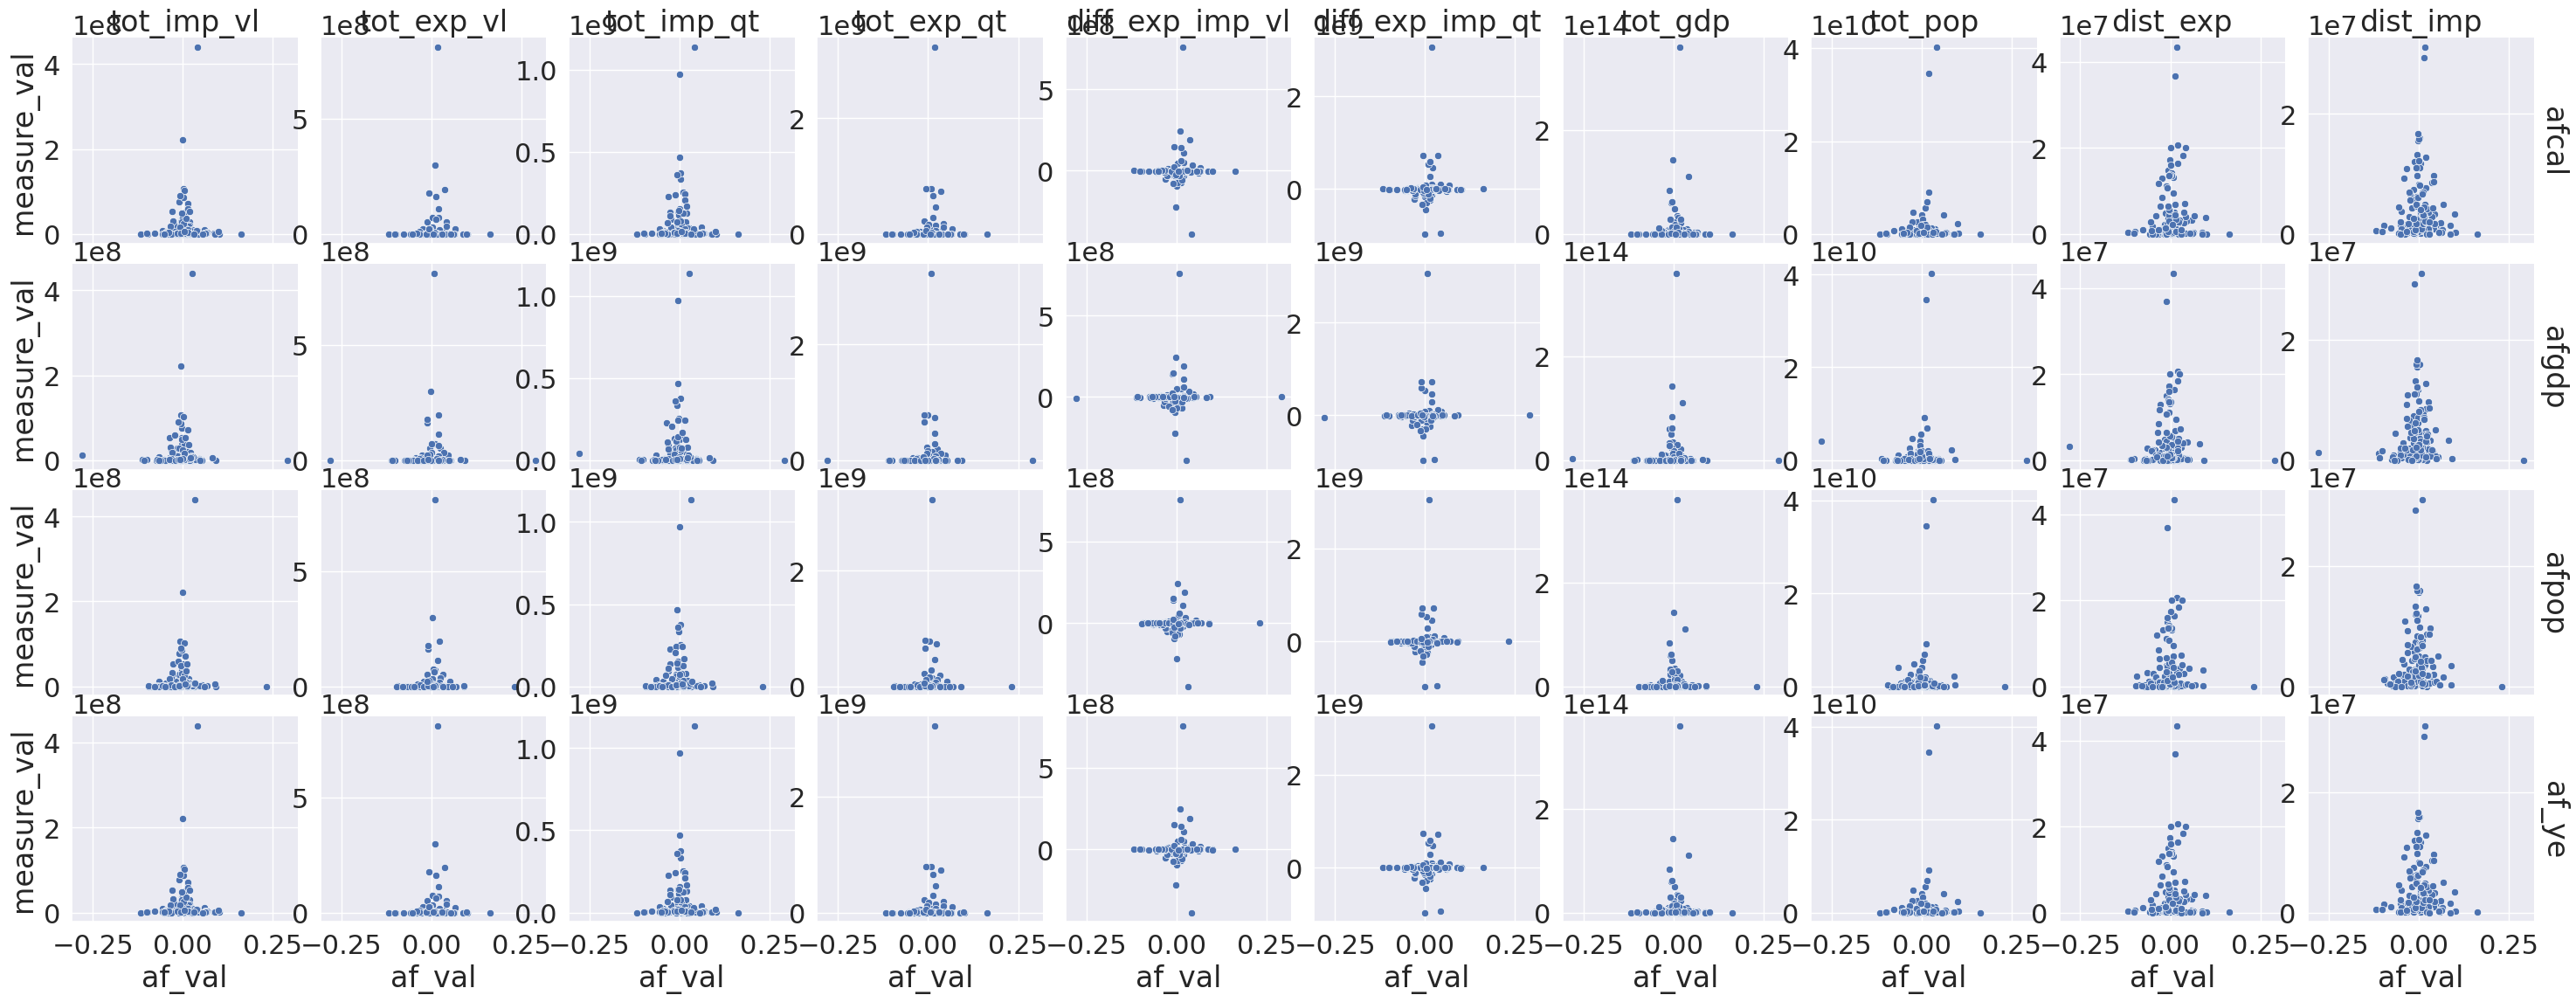

In [62]:
g=sns.FacetGrid(avg_af_measure,col='measure',row='af',margin_titles=True,sharey=False)
g.map(sns.scatterplot,'af_val','measure_val')
g.fig.subplots_adjust(wspace=.1, hspace=.1)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

In [16]:
# calories data
dict_100g_kcal = {
'Maize': 356,
'Chick peas' : 358,
'Rice - total  (Rice milled equivalent)' : 360,
'Wheat': 334,
'Beans, dry': 341,
'Groundnuts, shelled' : 567,
'Soybeans': 335,
'Oats': 385,
'Barley': 332,
'Millet': 340,
'Sorghum': 343
}

df_caloric=df.copy()
df_caloric['caloric']=df_caloric['Item'].map(dict_100g_kcal)


# distance data
# distances_YEI=pd.read_csv('../normalization/distan_datasets/distances_YEI_v2.csv',index_col=0)

#population data
df_pop=pd.read_csv('../normalization/gdp_pop_datasets_V3/pop_concurrent.csv')

#gdp data
df_gdp=pd.read_csv('../normalization/gdp_pop_datasets_V3/gdp_concurrent.csv')

In [18]:
to_norm_test=df_caloric.merge(df[['exporter','importer','Item','Year']],
                    how='inner',on=['exporter','importer','Year'])
caloric_table=to_norm_test.pivot_table(values='caloric',index='Year',columns='exporter',aggfunc=sum)
def zeros_nan(x):
    if x<1e-20:
        return np.nan
    else:
        return x
caloric_table=caloric_table.applymap(lambda x:zeros_nan(x))
caloric_table=caloric_table.drop(index=1986)

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

In [122]:
af_ex_pr=dict_afs['afgdp'].groupby(['Unnamed: 0']).mean()['af_ex_pr'].to_frame()
kbins=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='quantile')
data_discrt = kbins.fit_transform(af_ex_pr.dropna())

In [123]:
classes=pd.cut(af_ex_pr.values.flatten(),kbins.bin_edges_[0],labels=['fragile','fragile-robust','robust','antifragile-robust','antifragile'])

In [124]:
af_ex_pr['classes'] = classes

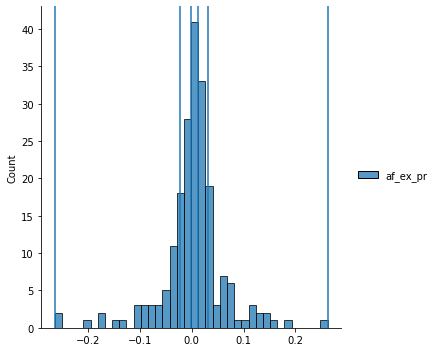

In [125]:
sns.displot(af_ex_pr)
for i in kbins.bin_edges_[0]:
    plt.axvline(i)